# Clase 24: Compilación, Paralelismo y Computación Distribuida

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

**Profesor: Pablo Badilla**

## Objetivos de la clase:

- Aprender a optimizar código a través de `JIT`.
- Comprender el paralelismo de tareas.
- Aprender a paralelizar tareas por medio de funciones en `Joblib`
- Comprender la idea general de computación distribuida.
- Analizar las opciones para computación distribuida: `Dask` y `Ray`.

## Tipos de Lenguaje

Recuerdo: Tipos de Lenguaje

<br>
<center>
<img src='./resources/tipos_lenguajes.png' width=800 />
</center>


---

## Compiladores

<center>
<img src='./resources/numba.png' width=600/>
</center>

Un proyecto interesante la librería **`Numba`** la cual está enfocada en **analizar y compilar funciones de Python**. Compiladores como Numba, diseñados para compilar código en ejecución (y no previo a la ejecución) se denomina compiladores **JIT** (just in time). 

Numba permite compilar funciones individuales de Python usado una *máquina virtual de bajo nivel* o LLVM por sus siglas en inglés (LLVM es un conjunto de herramientas pensadas para escribir compiladores).

Por medio de LLVM Numba inspecciona funciones de Python y las compila utilizando una capa de representación intermedia similar a código *assembly*. La potencia de esta inspección radica en la inferencia de tipos de datos generando una versiones compiladas con tipos de datos estáticos.

Numba se basa principalmente en el decorador `@jit` con el cual se definen las funciones a compilar.

**Ejemplo: Calcular el valor de $\pi$ usando Montecarlo**


Idea: 

<div align='center'>
<img src='./resources/montecarlo.png' width=300 />
<div/>
    
$$\frac{\text{area círculo}}{\text{area cuadrado}} = \frac{\pi r^2}{(2r)^2} $$

$$ 4* \frac{\text{area círculo}}{\text{area cuadrado}} = \pi $$


Y después simulamos que lanzamos puntos al azar a nuestra figura y contamos: 

$$ 4* \frac{\text{puntos en el circulo}}{\text{puntos en el cuadrado}} = \pi $$





Para comprobar el aumento de rendimiento de la compilación, usaremos 3 implementaciones distintas:
    
    1. Python.
    2. Numpy.
    3. Python con Numba.

### $\pi$ con Montecarlo en `Python`

In [1]:
import random


def monte_carlo_pi_python(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()

        if (x**2 + y**2) < 1.0:
            acc += 1

    return 4.0 * acc / nsamples

In [2]:
monte_carlo_pi_python(10000000)

3.1414848

In [3]:
%timeit monte_carlo_pi_python(100000)

19.9 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### $\pi$ con Montecarlo en `Numpy`

In [4]:
import numpy as np


def monte_carlo_pi_numpy(nsamples):
    acc = 0
    x = np.random.rand(nsamples)
    y = np.random.rand(nsamples)

    op = x**2 + y**2
    dentro_circulo = op[op < 1.0]

    return 4.0 * np.count_nonzero(dentro_circulo) / nsamples

In [5]:
monte_carlo_pi_numpy(100000)

3.1402

In [6]:
%timeit monte_carlo_pi_numpy(100000)

1.92 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### $\pi$ con Montecarlo en `Numba`

Y ahora probamos con una función compilada usando el decorador `@jit`.

In [7]:
import random

from numba import jit


@jit(nopython=True)
def monte_carlo_pi_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()

        if (x**2 + y**2) < 1.0:
            acc += 1

    return 4.0 * acc / nsamples

In [11]:
monte_carlo_pi_numba(100000)

3.13996

In [12]:
%timeit monte_carlo_pi_numba(100000)

632 µs ± 8.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Numba y Numpy

`Numba` también está diseñado para funcionar en conjunto con `numpy`

In [13]:
@jit(nopython=True)
def monte_carlo_pi_numpy_numba(nsamples):
    acc = 0
    x = np.random.rand(nsamples)
    y = np.random.rand(nsamples)

    op = x**2 + y**2
    dentro_circulo = op[op < 1.0]

    return 4.0 * np.count_nonzero(dentro_circulo) / nsamples

In [14]:
monte_carlo_pi_numpy_numba(100000)

3.13692

In [15]:
%timeit monte_carlo_pi_numpy_numba(100000)

852 µs ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Importante: `Numba` solo compila código de Python y `Numpy`

Está en general diseñado para optimizar tareas matemáticas y con ciclos.
No entiende librerías más complejas como `pandas` por ejemplo.





In [16]:
import pandas as pd

x = {"a": [1, 2, 3], "b": [20, 30, 40]}

In [17]:
def use_pandas(a):  # Function will not benefit from Numba jit
    df = pd.DataFrame.from_dict(a)  # Numba doesn't know about pd.DataFrame
    df += 1  # Numba doesn't understand what this is
    return df.cov()  # or this!

In [18]:
%timeit use_pandas(x)

309 µs ± 8.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
@jit
def use_pandas(a):  # Function will not benefit from Numba jit
    df = pd.DataFrame.from_dict(a)  # Numba doesn't know about pd.DataFrame
    df += 1  # Numba doesn't understand what this is
    return df.cov()  # or this!

In [20]:
use_pandas(x)

/tmp/ipykernel_19177/1783315070.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "use_pandas" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_19177/1783315070.py (3)

File "../../../../../../../../tmp/ipykernel_19177/1783315070.py", line 3:
<source missing, REPL/exec in use?>

  @jit
/home/pablo/miniconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "use_pandas" was compiled in object mode without forceobj=True.

File "../../../../../../../../tmp/ipykernel_19177/1783315070.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/pablo/miniconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visi

,a,b
a,1.0,10.0
b,10.0,100.0


In [21]:
%timeit use_pandas(x)

337 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---

## Paralelismo

El paralelismo se basa en el uso de múltiples unidades de computo de manera simulánea, con el el fin de mejorar la eficiencia en rutinas de código. La idea principal consite en enfrentar un problema de programación, dividiendolo en subunidades independientes y utilizar los núcleos disponibles de la máquina para resolver tales subunidades en paralelo.

<img src='./resources/paralelo_vs_secuencial.jpeg'/>
<center>
Fuente: 
<a href='https://towardsdatascience.com/an-intro-to-parallel-computing-with-ray-d8503629485'>https://towardsdatascience.com/an-intro-to-parallel-computing-with-ray-d8503629485</a>
    
</center>



---

### Problemas Data Parallel

Los problemas **Data Parallel** son aquellas en las que se le aplica una función particular sobre todos los datos (por ejemplo, multiplicar una matriz por un escalar).


En este tipo de problema paralelizable, es importante que la función es exactamente la misma y que el calculo de esta es independiente de todas las otras funciones. Por lo mismo, estas tareas también son denominadas **perfectamente paralelizables**. 

Las operaciones elemento por elemento sobre arreglos poseen esta propiedad. 


<div align='center'>
<img src='./resources/cpu_gpu.jpg' width=500 />
</div>

<div align='center'>
    Fuente: 
<a href='https://www.nvidia.com/es-la/drivers/what-is-gpu-computing/'>Nvidia.</a>
</div>

  
Imaginense la cantidad de operaciones simples que una GPU puede lograr hacer en paralelo. Por ejemplo, sumar una matriz con otra elemento a elemento.
  



---

### Problemas Task Parallel

Los problemas task parallel son aquellos que ejecutan varias tareas distintas en distintos hilos/procesos sobre distintos procesadores.

<center>
<img src='./resources/paralelismo_memoria.png' width=500 />
</center>

<center>
Fuente:    
<a href='https://manningbooks.medium.com/explaining-mapreduce-with-ducks-f643c78e0b40'>https://manningbooks.medium.com/explaining-mapreduce-with-ducks-f643c78e0b40</a>
</center>

<br>


Por lo general, este tipo de tasks no son completamente independientes y necesitan compartir información. En estos casos, se debe tener en cuenta que la comunicación entre subunidades y los datos compartidos **quitan eficiencia** al problema que se resuelve, pues se incurre en *costos de comunicación*. 

La comunicación entre procesos es inherentemente costosa y puede llevar fallas de correctitud . Por lo general, se enfrenta el problema de costo de comunicación y correctud del manejo de memoria por medio de sistemas que se comunican por medio de **threads/hilos con memoria compartida** y **procesos con memoria distribuida**.

---

### Hilos de Procesamiento o Threads

En el caso de memoria compartida, las subunidades involucradas en el programa tienen acceso a un espacio común de memoria, este por lo general es de acceso rápido. 

Si bien esto solventa el problema de velocidad de comunicación, el problema de correctitud sigue latente, por lo que se hace necesario utilizar técnicas de **sincronización**. 

La manera usual en la que se implementan procesos de memoria compartida es por medio de **threads o hilos de ejecución**. Estos consisten en subtareas originadas de un proceso en particular y que comparten recursos. 


<center>
<img src='./resources/threads.jpg' width=500/>
</center>

<center>
Fuente:
<a href='https://www.cs.uic.edu/~jbell/CourseNotes/OperatingSystems/4_Threads.html'> https://www.cs.uic.edu/~jbell/CourseNotes/OperatingSystems/4_Threads.html </a>
</center>

---

### Procesos

Por otra parte, el concepto de memoria distribuida concibe cada subunidad como un proceso completamente separado del resto con su propio espacio de memoria asociado. En este caso, la comunicación entre procesos se debe manejar de manera explicita y es más costosa que en el caso de memoria compartida, sin embargo, se reduce el riesgo de generar errores en el manejo de memoria. 

Este tipo de paralelismos puede ser observadas en los distintos procesos que ejecuta nuestro computador.

<center>
<img src='./resources/thread_process.png' width=500/>
</center>


<center>
    Fuente:
    <a href='https://www.javamex.com/tutorials/threads/how_threads_work.shtml'>https://www.javamex.com/tutorials/threads/how_threads_work.shtml<a/>
</center>

    



---

### Threads y Procesos en Python

Python puede manejar threads pero dado el diseño de su interprete, por defecto, se puede ejecutar solo una tarea a la vez, esto se conoce como **GIL** (Global Interpreter Lock). GIL provoca que cada vez que un hilo ejecute una orden de Python, se genere un bloqueo que solo será liberado una vez la ejecución del hilo termine.

> **Esto hace que los hilos solo puedan ser ejecutados de manera secuencial.**

Es decir, Python no puede ejecutar 2 o más hilos de ejecución al mismo tiempo usando más de un procesador.


Aunque GIL evita la ejecución de hilos usando múltiples procesadores en paralelo, es posible utilizar procesos mediante algunas librerías. La principal es `multiprocessing`

Multiprocessing ofrece una interfaz sencilla que incluye múltiples herramientas para manejar sincronozación y ejecución de tareas. Es posible importar esta librería de manera estándar. 

```python
import multiprocessing
```

Es posible crear procesos independientes por medio la clase `Process`, para ello basta extender el método `__init__` para inicializar los datos a procesar y generar el método `run` sobre el cual se ejecuta el proceso.

**Ejemplo**
 
Se genera un proceso independiente utilizando la clase `Process`

In [22]:
import time
from multiprocessing import Process


class Proceso_independiente(Process):
    def __init__(self, num):
        super().__init__()
        self.num = num

    def run(self):
        print("Mi número:", self.num, "\nMe voy a dormir 10s 💤😴💤")
        time.sleep(10)
        print("Desperté 😃")

Para utilizar el proceso se instancia un objeto de la clase `Proceso_ind` y se llama el método `.start()` 

In [23]:
proc = Proceso_independiente(5)
proc.start()

Mi número: 5 
Me voy a dormir 10s 💤😴💤
Desperté 😃


In [24]:
proc = Proceso_independiente(10)
proc.start()

Mi número: 10 
Me voy a dormir 10s 💤😴💤
Desperté 😃


In [25]:
print("¿¿¿🤨??? Me puedo ejecutar sin esperar a que la celda anterior termine")

¿¿¿🤨??? Me puedo ejecutar sin esperar a que la celda anterior termine


**Obs**:En el ejemplo anterior, no fue necesario utilizar el metodo anulado `.run()`, este es llamado por `.start()` de manera interna.

En el caso en que se requiera esperar la finalización de un conjunto de tareas paralelas para luego recopilar resultados, es posible utilizar el método `.join()`.

In [26]:
proc = Proceso_independiente(5)
proc.start()
proc.join()

print("Aquí tuve que esperar 😔")

Mi número: 5 
Me voy a dormir 10s 💤😴💤
Desperté 😃
Aquí tuve que esperar 😔


Con la construcción actual, es posible levantar tantos procesos como se requiera, en esta caso se levantan 3 procesos.

In [27]:
import time
from multiprocessing import Process


class Proceso_independiente(Process):
    def __init__(self, num):
        super().__init__()
        self.num = num

    def run(self):
        print(f"Me voy a dormir 10s ({self.num})💤😴💤\n")
        time.sleep(10)
        print(f"Desperté ({self.num})😃\n")

In [28]:
# Se definen los 3 procesos
procesos = (
    Proceso_independiente(1),
    Proceso_independiente(2),
    Proceso_independiente(3),
)

# Se mide el tiempo de ejecucion
start = time.time()

# Iniciar todos los procesos
for p in procesos:
    p.start()

# Esperar a que terminen todos los procesos
for p in procesos:
    p.join()

end = time.time()


print("Tiempo de ejecución: ", end - start)

Me voy a dormir 10s (1)💤😴💤

Me voy a dormir 10s (2)💤😴💤

Me voy a dormir 10s (3)💤😴💤

Desperté (1)😃

Desperté (2)😃
Desperté (3)😃


Tiempo de ejecución:  10.037635564804077


Estos tres procesos corren de manera paralela, pues su tiempo de ejecución total es aproximado al tiempo de ejecución individual. 

Es necesario comprender que el orden de ejecución de procesos paralelos no es necesariamente ordenando y predecible pues depende de cómo el sistema operativo asigne los recursos. 

### Memoria Compartida y Dataraces

Un data race es una situación que ocurre cuando uno o más hilos acceden concurrentemente a una posición de memoria o variable, al menos uno está escribiendo y al menos uno no está sincronizado con los otros hilos.

<div align='center'>
<img src='./resources/datarace_1.png' width=400/>
</div>

<div align='center'>
    Ejecución secuencial en memoria compartida por threads.
    Fuente: <a href='https://en.wikipedia.org/wiki/Race_condition'>Wikipedia</a>
</div>

<br>
<br>

<div align='center'>
<img src='./resources/datarace_2.png' width=400/>
</div>

<div align='center'>
    Ejecución paralela en memoria compartida por threads.
    Fuente: <a href='https://en.wikipedia.org/wiki/Race_condition'>Wikipedia</a>
</div>

<br>

**La solución es tener mecanismos de sincronización** de hilos. 



### Ejemplo en `multiprocessing`


El comportamiento predeterminado de `multiprocessing` es generar procesos con memoria independiente, sin embargo, permite definir ciertas variables en memoria compartida. Para definir una variable en memoria compartida se utiliza la clase `Value`, a esta clase se le entrega un tipo de dato que puede ser `i` para entero, `f` para flotante, `d` para doble precisión entre otros. 


In [29]:
from multiprocessing import Value

comp_var = Value("d")

Al utilizar variables en memoria compartida se deben tener en cuenta los procesos que acceden a ella, manejando la *concurrencia*, es decir, si los procesos pueden acceder a dichas variables de manera simultanea u ordenada. Por lo general en la actualización de valores unidimensionales se debe tener en cuenta la concurrencia bloqueando el acceso simultaneo. En arreglos se puede permitir tal manipulación siempre que los computos sean independientes. 

Para bloquear el acceso a una variable compartida se hace uso de la clase `Lock`.

In [30]:
from multiprocessing import Lock

lock = Lock()

A continuación se genera una rutina que accede a una variable de memoria compartida

In [31]:
from multiprocessing import Process, Value


class Process_shared(Process):
    def __init__(self, var, n=10000):
        super().__init__()
        self.var = var
        self.n = n

    def run(self):
        for i in range(self.n):
            self.var.value += 1

El proceso asociado toma un valor y le añade 1 hasta `n = 10000` veces por proceso. Se crea el valor inicial y se inicializan 3 procesos

In [32]:
def test():
    var = Value("i")
    var.value = 0

    procs = [Process_shared(var) for i in range(3)]

    for p in procs:
        p.start()

    for p in procs:
        p.join()

    print(var.value)

Se prueba el resultado

In [52]:
test()

27092


Como se puede ver, el resultado no es necesariamente 30.000, esto se debe al acceso simultaneo y aleatorio de los procesos a `var`, para solucionar este problema se hace uso de `lock`, para ello se redefine la clase `Process_shared` observando que lock es un *context manager*

In [53]:
class Process_shared_lock(Process):
    def __init__(self, var, n=10000):
        super().__init__()
        self.var = var
        self.n = n

    def run(self):
        for i in range(self.n):
            with lock:
                self.var.value += 1

Se redefine la prueba asociada y se ejecuta:

In [62]:
def test():
    var = Value("i")
    var.value = 0

    procs = [Process_shared_lock(var) for i in range(3)]

    [p.start() for p in procs]
    [p.join() for p in procs]

    print(var.value)


test()

30000


Con lo cual se obtiene el resultado buscado.

Sin embargo, coordinar procesos más complejos se torna tedioso y complejo, además de ser susceptible a errores.
Por lo general, se recomienda, a menos que sea estrictamente necesario, a librerías que facilitan la paralelización, como las que vamos a ver a continuación.

---

### Paralelización con `Joblib`



<div align='center'>
    <img src='./resources/joblib.png' width=200>
</div>

Otra forma de paralelizar de forma relativamente sencilla es usar la librería `joblib`. 
Esta permite ejecutar funciones de forma paralela similar a un map. Es decir, le entregamos una lista de argumentos y ejecuta una función con dichos argumentos de forma paralela.

Para esto, utiliza el decorador `delayed` sobre una función (lo que la transforma a lazy, es decir, no se ejecuta instantaneamente). Luego a través del objeto `Parallel` que toma el número de trabajos concurrentes que se ejecutarán (`n_jobs`) ejecuta las funciones con sus parámetros.

El siguiente ejemplo veremos como paralelizar el cálculo de coseno sobre una lista:

In [63]:
import numpy as np

[np.cos(i) for i in np.arange(0, 1, 0.1)]

[1.0,
 0.9950041652780258,
 0.9800665778412416,
 0.955336489125606,
 0.9210609940028851,
 0.8775825618903728,
 0.8253356149096782,
 0.7648421872844884,
 0.6967067093471654,
 0.6216099682706644]

La notación es muy similar a un list comprehension, solo que con 2 diferencias:

- Se reemplazan los corchetes exteriores `[f(i) for i in ...]` por paréntesis `(f(i) for i in ...)` (Esto da lugar a un generador en vez de una lista).
- Se encapsula la función a aplicar a cada elemento con la función `delayed`, o sea, `f(i)` por `delayed(f)(i)`.

Luego, lo anterior se le pasa como argumento a un Parallel.


In [66]:
from math import sqrt

from joblib import Parallel, delayed

# n_jobs=-1 indica que se usarán todos los procesadores disponibles.
Parallel(n_jobs=-1)(delayed(np.cos)(i) for i in np.arange(0, 1, 0.1))

[1.0,
 0.9950041652780258,
 0.9800665778412416,
 0.955336489125606,
 0.9210609940028851,
 0.8775825618903728,
 0.8253356149096782,
 0.7648421872844884,
 0.6967067093471654,
 0.6216099682706644]

In [64]:
%timeit [np.cos(i) for i in np.arange(0, 1, 0.001)]

811 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [67]:
%timeit Parallel(n_jobs=-1)(delayed(np.cos)(i) for i in np.arange(0, 1, 0.001))

148 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Para tareas numéricas no es tan efectivo (ya existe un cierto overhead/coste de generar los subprocesos), pero para tareas pesadas, se comporta bastante bien.

Para este ejemplo, leeremos 50 veces archivo con números aleatorios en forma secuencial y en forma paralelizada:

In [68]:
import pandas as pd


def leer_archivo(_):
    _ = pd.read_csv("./resources/num_aleatorios.csv")

In [69]:
%timeit [leer_archivo(_) for _ in range(0, 100)]

3.57 s ± 75.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
%timeit Parallel(n_jobs=-1)(delayed(leer_archivo)(_) for _ in range(0, 100))

1.2 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ahora si notamos diferencias.

### Asincronía y Corrutinas

<center>
<img src='./resources/corrutinas.png' />
</center>

En general, se utiliza más en el desarrollo web/software para no bloquear la ejecución de código al solicitar datos a un servidor externo.

## Procesamiento Distribuido

<img src='./resources/distributed.png'/>

El procesamiento distribuido hace referencia a la ejecución de tareas utilizando múltiples máquinas. Por lo general se refiere al trabajo con clusters de procesamiento y suele llevarse a cabo por medio de herramientas como `Dask` o `Ray`.

En Python existen diversas librerías que permiten computación distribuida. En esta última sección estudiaremos `Dask` y `Ray` para procesar `DataFrames`.



### `Dask`
<div align='center'>
<img src='./resources/dask.jpg' width=300>
</div>

Dask permite escalar procesos de Python (ya sea en un computador personal o un cluster) de manera sencilla. Provee de funcionalidades para tratar, por medio de procesamiento multi-core, con datsets masivos **que por lo general no caben en memoria.**

`Dask` fue implementado como un reemplazo de `Numpy` y `Pandas`, por ende su interfaz de usuario (API) es muy similar.
Los `DataFrames` de Dask son en términos prácticos conjuntos de `DataFrames` de pandas. Dicha separación permite ejecutar operaciones distribuidas y paralelas de forma muy eficiente.



<div align='center'>
<img src='./resources/dask.png' width=600 />
</div>

<center>
<img src='./resources/dask_mimic.png' width=700>
</center>

Pueden encontrar mayor información en la página oficial del proyecto:

https://docs.dask.org/en/latest/

In [ ]:
!python -m pip install "dask[dataframe]"

#### Pandas vs Dask

##### Datos aleatorios con `pd.DataFrame`

In [71]:
import numpy as np
import pandas as pd

# generamos datos aleatorios
df = pd.DataFrame(np.random.random((500000,200)))

# generamos categorías a partir de bins para luego agregar
df[0] = pd.cut(df[0], 20)
df[1] = pd.cut(df[1], 20)
df[2] = pd.cut(df[2], 20)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 200 entries, 0 to 199
dtypes: category(3), float64(197)
memory usage: 752.9 MB


La prueba será cuanto se demora en ejecutar un `groupby(..).mean()` sobre las categorías generadas:

In [73]:
df.groupby([0, 1, 2]).mean()

3         4    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.456713  0.480688   
                                    (0.05, 0.1]        0.491253  0.502542   
                                    (0.1, 0.15]        0.495844  0.501095   
                                    (0.15, 0.2]        0.504743  0.473638   
                                    (0.2, 0.25]        0.485220  0.397442   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.513605  0.506260   
                                    (0.8, 0.85]        0.464984  0.501557   
                                    (0.85, 0.9]        0.501063  0.482373   
                                    (0.9, 0.95]        0.546040  0.525331   
                                    (0.95, 1.0]        0.534457  0.464743   

                                                            5         6    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.513211  0.455270   
                                    (0.05, 0.1]        0.476180  0.536835   
                                    (0.1, 0.15]        0.426063  0.531228   
                                    (0.15, 0.2]        0.489735  0.460374   
                                    (0.2, 0.25]        0.512983  0.493876   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.585189  0.584033   
                                    (0.8, 0.85]        0.451458  0.501338   
                                    (0.85, 0.9]        0.446376  0.510084   
                                    (0.9, 0.95]        0.507346  0.438360   
                                    (0.95, 1.0]        0.536689  0.596735   

                                                            7         8    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.533285  0.457570   
                                    (0.05, 0.1]        0.479392  0.547372   
                                    (0.1, 0.15]        0.568009  0.508729   
                                    (0.15, 0.2]        0.531248  0.412992   
                                    (0.2, 0.25]        0.483961  0.568941   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.517697  0.532895   
                                    (0.8, 0.85]        0.519423  0.467209   
                                    (0.85, 0.9]        0.439371  0.454400   
                                    (0.9, 0.95]        0.497925  0.511941   
                                    (0.95, 1.0]        0.438535  0.546107   

                                                            9         10   \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.574969  0.501885   
                                    (0.05, 0.1]        0.529670  0.476982   
                                    (0.1, 0.15]        0.426326  0.453618   
                                    (0.15, 0.2]        0.499780  0.535829   
                                    (0.2, 0.25]        0.491762  0.524784   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.489777  0.425689   
                                    (0.8, 0.85]        0.520436  0.481513   
                                    (0.85, 0.9]        0.501757  0.424803   
                                    (0.9, 0.95]        0.463298  0.509609   
                                    (0.95, 1.0]        0.464315  0.609160   

                                                    

##### Inicializar `dask.dataframe`

Ahora, generamos un `Dask DataFrame` desde pandas

In [74]:
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=5)
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 200 entries, 0 to 199
dtypes: category(1), category(1), category(1), float64(197)

Vemamos que pasa si hacemos la misma operación que antes:

In [75]:
ddf.groupby([0, 1, 2]).mean()

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


No produjo ningún resultados. Esto es porque Dask es **Lazy**, es decir, se ejecuta solo cuando alguien demanda su ejecución.
Esto se puede lograr a partir del método `compute()`:


In [76]:
ddf.groupby([0, 1, 2]).mean().compute()

3         4    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.456713  0.480688   
                                    (0.05, 0.1]        0.491253  0.502542   
                                    (0.1, 0.15]        0.495844  0.501095   
                                    (0.15, 0.2]        0.504743  0.473638   
                                    (0.2, 0.25]        0.485220  0.397442   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.513605  0.506260   
                                    (0.8, 0.85]        0.464984  0.501557   
                                    (0.85, 0.9]        0.501063  0.482373   
                                    (0.9, 0.95]        0.546040  0.525331   
                                    (0.95, 1.0]        0.534457  0.464743   

                                                            5         6    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.513211  0.455270   
                                    (0.05, 0.1]        0.476180  0.536835   
                                    (0.1, 0.15]        0.426063  0.531228   
                                    (0.15, 0.2]        0.489735  0.460374   
                                    (0.2, 0.25]        0.512983  0.493876   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.585189  0.584033   
                                    (0.8, 0.85]        0.451458  0.501338   
                                    (0.85, 0.9]        0.446376  0.510084   
                                    (0.9, 0.95]        0.507346  0.438360   
                                    (0.95, 1.0]        0.536689  0.596735   

                                                            7         8    \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.533285  0.457570   
                                    (0.05, 0.1]        0.479392  0.547372   
                                    (0.1, 0.15]        0.568009  0.508729   
                                    (0.15, 0.2]        0.531248  0.412992   
                                    (0.2, 0.25]        0.483961  0.568941   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.517697  0.532895   
                                    (0.8, 0.85]        0.519423  0.467209   
                                    (0.85, 0.9]        0.439371  0.454400   
                                    (0.9, 0.95]        0.497925  0.511941   
                                    (0.95, 1.0]        0.438535  0.546107   

                                                            9         10   \
0                 1                 2                                       
(-0.000999, 0.05] (-0.000997, 0.05] (-0.000998, 0.05]  0.574969  0.501885   
                                    (0.05, 0.1]        0.529670  0.476982   
                                    (0.1, 0.15]        0.426326  0.453618   
                                    (0.15, 0.2]        0.499780  0.535829   
                                    (0.2, 0.25]        0.491762  0.524784   
...                                                         ...       ...   
(0.95, 1.0]       (0.95, 1.0]       (0.75, 0.8]        0.489777  0.425689   
                                    (0.8, 0.85]        0.520436  0.481513   
                                    (0.85, 0.9]        0.501757  0.424803   
                                    (0.9, 0.95]        0.463298  0.509609   
                                    (0.95, 1.0]        0.464315  0.609160   

                                                    

Incluso se puede visualizar como se computa la operación distribuida a través de el siguiente método:


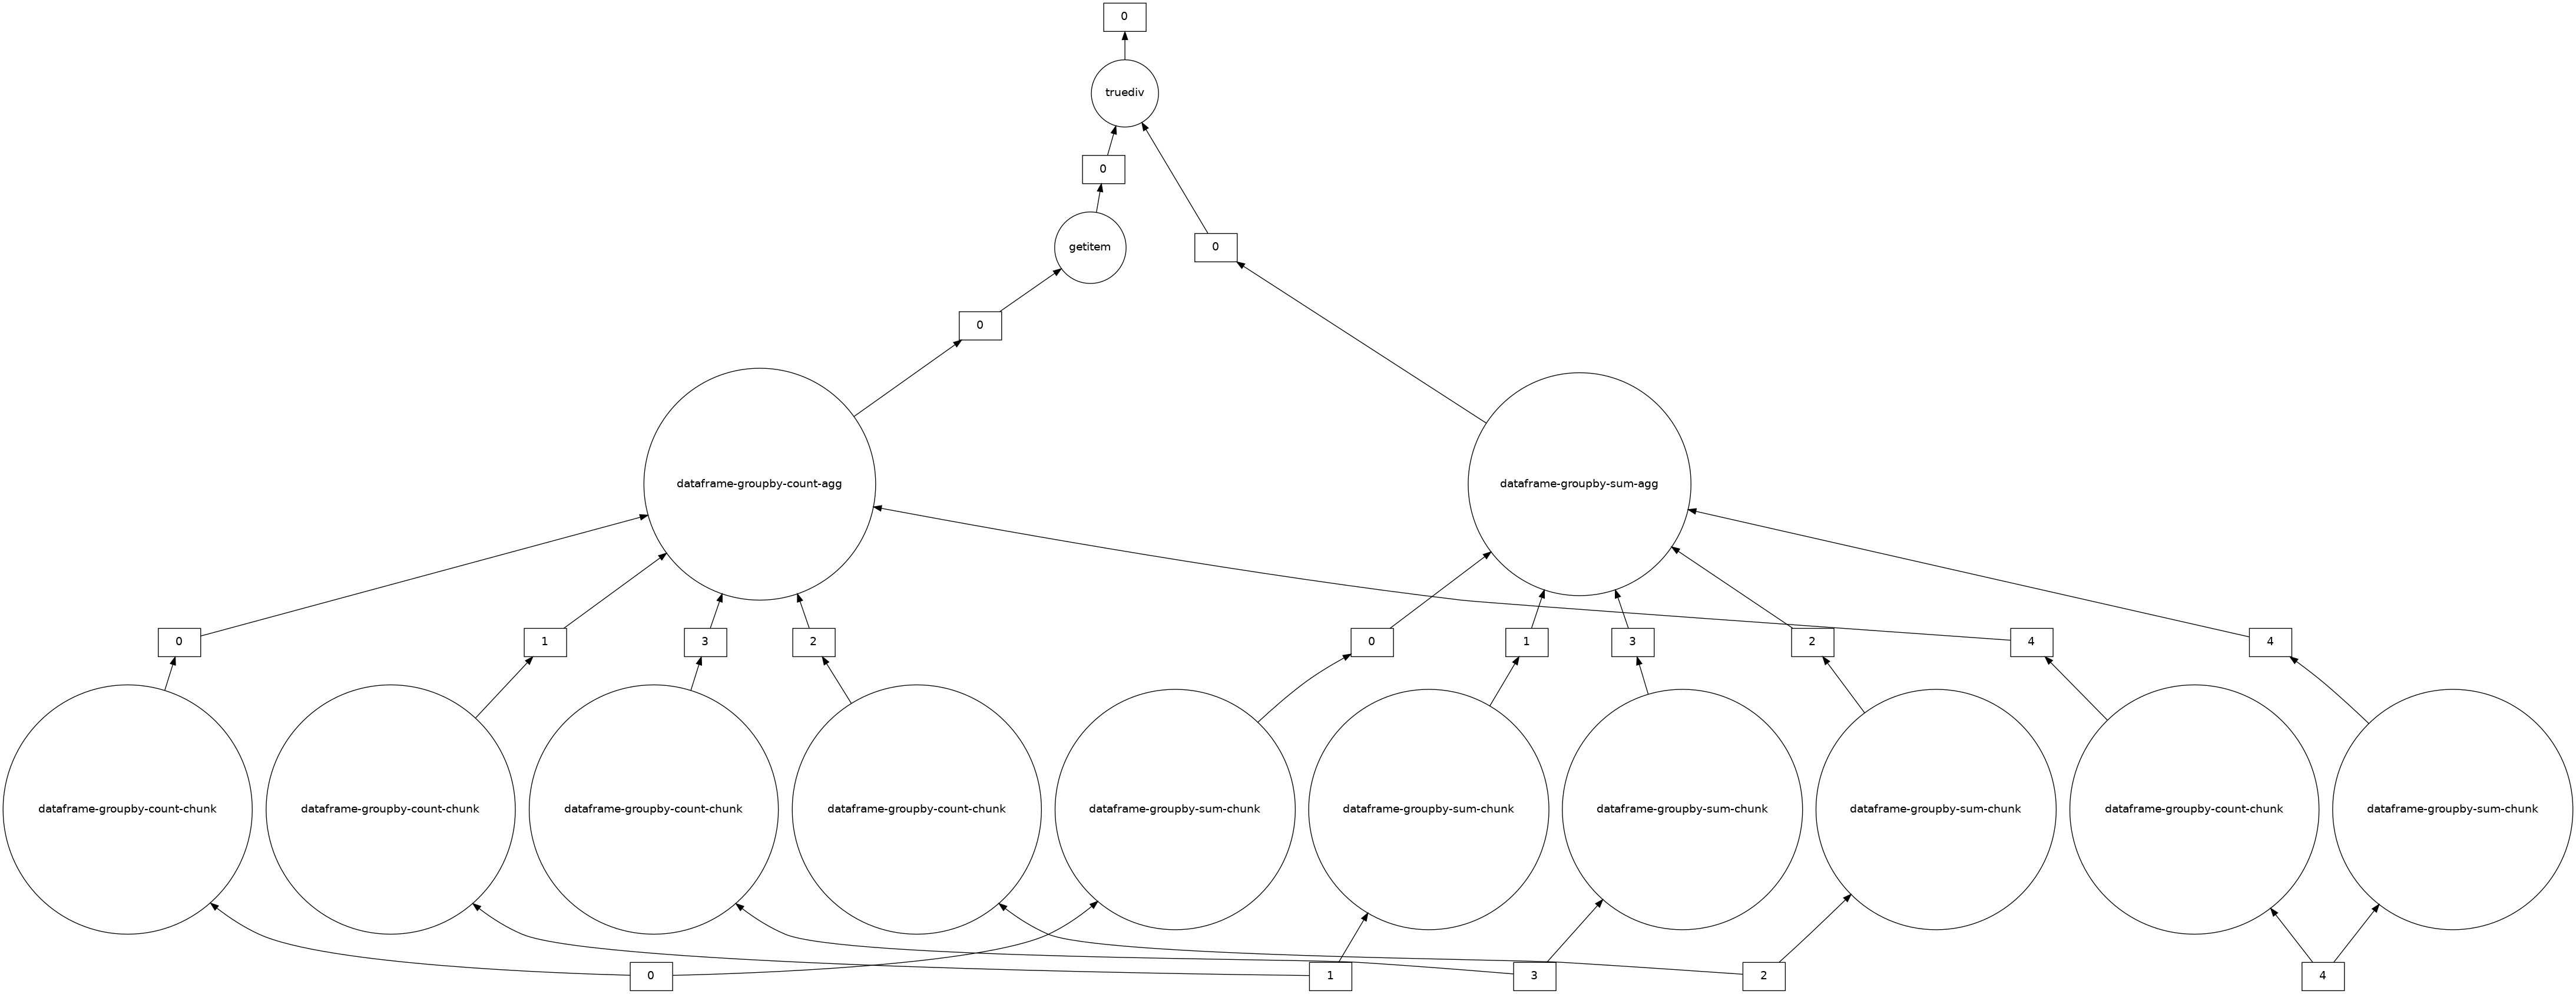

In [77]:
ddf.groupby([0, 1, 2]).mean().visualize()

##### Comparación de tiempos

En las siguientes celdas ejecutamos al comparación de tiempos

In [78]:
%timeit df.groupby([0, 1, 2]).mean()

725 ms ± 66.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%timeit ddf.groupby([0, 1, 2]).mean().compute()

1.54 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Podemos ver que **Dask** no es más rápido que **pandas** para la cantidad de datos anterior `(500000 x 200) ~ 752.9 MB`.

Nuevamente, esto se debe al overhead / gasto adicional que implica lanzar varios procesos para ejecutar tareas en paralelo.

### `Ray`
<div align='center'>
<img src='./resources/ray.png' width=400>
</div>

Ray está diseñado para ser un framework un poco más general y no enfocado necesariamente en procesamiento de datos. Sus interfaces de procesamiento son muy similares a las de JobLib: envuelve funciones y objetos, que luego pueden ser ejecutados de forma paralelizada y distribuida.

Es importante mencionar que, a diferencia de dask, no tiene interfaces similares a `Pandas` ni a `Numpy`; sin emabrgo, puede ejecutarlas y paralelizarlas.

<div align='center'>
<img src='./resources/ray_ecosystem_integration_v2.png/' width=600>
</div>

Para el caso de los DataFrames, podemos usar `Modin`, un paquete construido sobre `Ray` que simula el comportamiento de dichas estructuras de datos. Link al proyecto: https://modin.readthedocs.io/en/stable/
<br>


<div align='center'>
<img src='./resources/modin.png' width=500>
</div>

<br>

In [ ]:
!pip install ray
!pip install modin[ray]

#### Versión `Pandas`

In [80]:
import numpy as np
import pandas as pd

# generamos datos aleatorios
df = pd.DataFrame(np.random.random((500000,200)))

# generamos categorías a partir de bins para luego agregar
df[0] = pd.cut(df[0], 20)
df[1] = pd.cut(df[1], 20)
df[2] = pd.cut(df[2], 20)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 200 entries, 0 to 199
dtypes: category(3), float64(197)
memory usage: 752.9 MB


### Con Ray + Modin

In [81]:
import ray
import os

ray.init(ignore_reinit_error=True, num_cpus=os.cpu_count(), )

import modin.pandas as mpd # comunmente se importa como pd, al igual que pandas
import numpy as np

2022-06-14 18:38:53,700	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


In [82]:
mdf = mpd.DataFrame(np.random.random((500000,200)))
# generamos categorías a partir de bins para luego agregar
mdf[0] = mpd.cut(mdf[0], 20)
mdf[1] = mpd.cut(mdf[1], 20)
mdf[2] = mpd.cut(mdf[2], 20)

mdf.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 200 entries, 0 to 199
dtypes: float64(197), category(1), category(1), category(1)
memory usage: 752.9 MB


En este caso, al igual que en pandas, se calcula sin la necesidad de llamar al método `compute`.

In [83]:
mdf.groupby([0, 1, 2]).mean()

3         4    \
0              1                 2                                       
(-0.001, 0.05] (-0.000992, 0.05] (-0.000999, 0.05]  0.479869  0.513240   
                                 (0.05, 0.1]        0.498624  0.530025   
                                 (0.1, 0.15]        0.517209  0.461041   
                                 (0.15, 0.2]        0.512270  0.453088   
                                 (0.2, 0.25]        0.508107  0.473116   
...                                                      ...       ...   
(0.95, 1.0]    (0.95, 1.0]       (0.75, 0.8]        0.529975  0.503145   
                                 (0.8, 0.85]        0.500692  0.487651   
                                 (0.85, 0.9]        0.591071  0.513053   
                                 (0.9, 0.95]        0.526067  0.526060   
                                 (0.95, 1.0]        0.519127  0.478994   

                                                         5         6    \
0              1                 2                                       
(-0.001, 0.05] (-0.000992, 0.05] (-0.000999, 0.05]  0.491179  0.489826   
                                 (0.05, 0.1]        0.437983  0.526539   
                                 (0.1, 0.15]        0.528766  0.506850   
                                 (0.15, 0.2]        0.466021  0.480955   
                                 (0.2, 0.25]        0.488733  0.435610   
...                                                      ...       ...   
(0.95, 1.0]    (0.95, 1.0]       (0.75, 0.8]        0.513054  0.515244   
                                 (0.8, 0.85]        0.492442  0.555624   
                                 (0.85, 0.9]        0.462937  0.487697   
                                 (0.9, 0.95]        0.493719  0.500063   
                                 (0.95, 1.0]        0.483169  0.468316   

                                                         7         8    \
0              1                 2                                       
(-0.001, 0.05] (-0.000992, 0.05] (-0.000999, 0.05]  0.480539  0.412664   
                                 (0.05, 0.1]        0.487046  0.439638   
                                 (0.1, 0.15]        0.570002  0.502854   
                                 (0.15, 0.2]        0.466451  0.534027   
                                 (0.2, 0.25]        0.448484  0.454192   
...                                                      ...       ...   
(0.95, 1.0]    (0.95, 1.0]       (0.75, 0.8]        0.460933  0.543789   
                                 (0.8, 0.85]        0.537531  0.422546   
                                 (0.85, 0.9]        0.570164  0.459808   
                                 (0.9, 0.95]        0.448871  0.500506   
                                 (0.95, 1.0]        0.489308  0.513707   

                                                         9         10   \
0              1                 2                                       
(-0.001, 0.05] (-0.000992, 0.05] (-0.000999, 0.05]  0.491341  0.555464   
                                 (0.05, 0.1]        0.555047  0.525565   
                                 (0.1, 0.15]        0.515523  0.499922   
                                 (0.15, 0.2]        0.500550  0.449459   
                                 (0.2, 0.25]        0.506368  0.552616   
...                                                      ...       ...   
(0.95, 1.0]    (0.95, 1.0]       (0.75, 0.8]        0.497652  0.524364   
                                 (0.8, 0.85]        0.490989  0.513841   
                                 (0.85, 0.9]        0.499739  0.536244   
                                 (0.9, 0.95]        0.490606  0.526493   
                                 (0.95, 1.0]        0.493160  0.474876   

                                                         11        12   ...  \
0              1                 2                                      ...   
(-0.001, 0.05] (-0.000992, 0.05] (-0.000999, 0.

#### Midiendo tiempos

In [84]:
%timeit df.groupby([0, 1, 2]).mean()

740 ms ± 70 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%timeit mdf.groupby([0, 1, 2]).mean()

1.45 s ± 376 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Debo usar estos frameworks?

Si tu dataset cabe en memoria comodamente y no es muy grande, entonces no es necesario usar ni `Dask` ni `Ray`. Simplemente agregará una capa de complejidad al desarrollo.

Por otra parte, si el dataset con el cuál están trabajando es masivo, entonces dichas librerías son un buen factor a considerar.

## Y para usar la GPU?

Pueden utilizar estas alternativas:

- [Cupy](https://docs.cupy.dev/en/stable/user_guide/basic.html) - Implementación de `NumPy/SciPy` usando `CUDA` (para GPUs nvidia)
- [Rapids](https://rapids.ai/start.html): Colección de librerías basadas en `CUDA` que al igual que la alternativa anterior, mejora el rendimiento a través de la GPU.